# Introduction
This project aims to automate zooplankton classification using geometric and environmental features. Zooplankton are vital indicators of lake ecosystem health, serving as a crucial link in the food web by feeding on phytoplankton and becoming a food source for fish.

Fishing in Ontario's lakes has a significant economic impact. According to Ontario News (https://news.ontario.ca/en/release/1005496/ontario-boosting-its-fish-populations), more than 1.5 million anglers contribute $1.6 billion annually to the economy.


# Data
I used data from the Ministry of Natural Resources and Forestry, Ontario. The dataset consists of .tif mosaics containing zooplankton images, along with geometric and environmental features. For example, each plankton image includes attributes such as transparency, symmetry, latitude, and longitude.

The classification model will use the "Class" column, focusing on classifying seven classes: Calanoid_1, Cyclopoid_1, Bosmina_1, Harpacticoida, Chironomid, Chydoridae, and Daphnia.

The data comes from two lakes in Ontario: Lake Huron and Lake Simcoe. However, the dataset is highly imbalanced, and some geometric features and labels may be missing.

# Methods
## Data processing
Before applying classification models, I merged all available data from Lake Simcoe for training and testing.

As shown in the Distribution of calss histogram below, the `'TooSmall'` class accounts for 51.25% of the dataset. Since this class provides no meaningful information about plankton (as these samples were too small to classify), I decided to exclude them to prevent introducing significant noise into the model. 

There were also some outliers that negatively affected model performance. As you can see in the graph, because of few outliers regular sized planktons cannot be shown in histograms. I removed them for two main reasons:

1. They are not plankton but misclassified source data.  
   For example, after removing the "TooSmall" class, the image with the largest `Area..ABD.` value is from the file  
   `20180529_Simcoe_200_2mm_rep2_redo_000002.tif` and is labeled `'CountGT500'`.  
   When cropping other `'CountGT500'` images from the same `.tif` file, one appears extremely large and clearly not a plankton.  
   You can verify this in the GitHub repository:  
   `crop_images/big_particles/20180529_SIMC_200_2mm_rep2_redo_KG_data`

2. Although some large plankton species exist, most of the top 100 largest images by area are clearly not relevant:  
   - 54% are labeled as `Floc_1`
   - 25% as `Bubbles`
   - 20% as `CountGT500`

Since Floc refers to clusters of aggregated particles (not actual organisms), removing these samples does not interfere with our goal of classifying the seven target classes.

### Area Threshold Justification

I set the exclusion threshold at:

\\[
\text{Area..ABD.} > 2{,}000{,}000
\\]

Here's why:

- The largest target class is `Calanoid_1`, which is typically less than 1.5 mm in length  
  ([USGS Fact Sheet](https://nas.er.usgs.gov/queries/FactSheet.aspx?speciesID=178#:~:text=Eurytemora%20affinis%20is%20around%201,that%20is%20more%20than))

- Assuming a circular or elliptical shape, we can estimate the area as:

\\[
\text{Area} = \frac{\pi}{4} \cdot \text{length}^2 \approx \frac{\pi}{4} \cdot (1.5)^2 \approx 1.76 \text{ mm}^2
\\]

- Using a slightly more generous threshold of 1.5 mm², this translates to an `Area..ABD.` of about 1,500,000 in our data's scale.

- This threshold corresponds to the 99.53rd percentile, so removing these outliers excludes only the top 0.47% of the data.

### Feature Scaling and Dimensionality Reduction

Since many features are heavily right-skewed, I applied a log transformation to positively skewed data. Additionally, I performed standardization since most features have a large range.

The covariance matrix revealed some highly correlated features, which could lead to multicollinearity. To address this, I used Principal Component Analysis (PCA) with 10 principal components. The number of components was determined using the elbow point from the scree plot, as shown in the graph below.

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

original_df = pd.read_csv(r'C:\Users\sprin\Downloads\SIMC_OverlapTiffsWithPP\SIMC_OverlapTiffsWithPP\SIMC.Overlap.csv\merged_data.csv')

feature_cols = [
    "Area..ABD.", "Area..Filled.", "Width", "Length", "Volume..ABD.", "Volume..ESD.", 
    "Diameter..ABD.", "Diameter..ESD.", "Feret.Angle.Max", "Feret.Angle.Min", "Symmetry", 
    "Circularity", "Convexity", "Aspect.Ratio", "Compactness", "Elongation", "Fiber.Curl", 
    "Fiber.Straightness", "Roughness", "Transparency", "Sum.Intensity", "Intensity", 
    "Sigma.Intensity", "Edge.Gradient"
]
target_col = "Class"

# Plot the distribution of classes
class_counts = original_df[target_col].value_counts()

In [60]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df = original_df[(original_df[target_col] != 'TooSmall') & (original_df["Area..ABD."] <= 1_500_000)]

X = df[feature_cols]
y = df[target_col]

# columns with right-skewed distribution
log_transform_cols = [
    "Area..ABD.", "Area..Filled.", "Width", "Length", "Volume..ABD.", "Volume..ESD.", 
    "Diameter..ABD.", "Diameter..ESD.", "Compactness", "Elongation", "Fiber.Curl", 
    "Roughness", "Sum.Intensity"
]

# log transform
X.loc[:, log_transform_cols] = X[log_transform_cols].apply(lambda x: np.log1p(x))

# standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# scree plot
pca_full = PCA()
pca_full.fit(X_scaled)

explained_variance = pca_full.explained_variance_ratio_

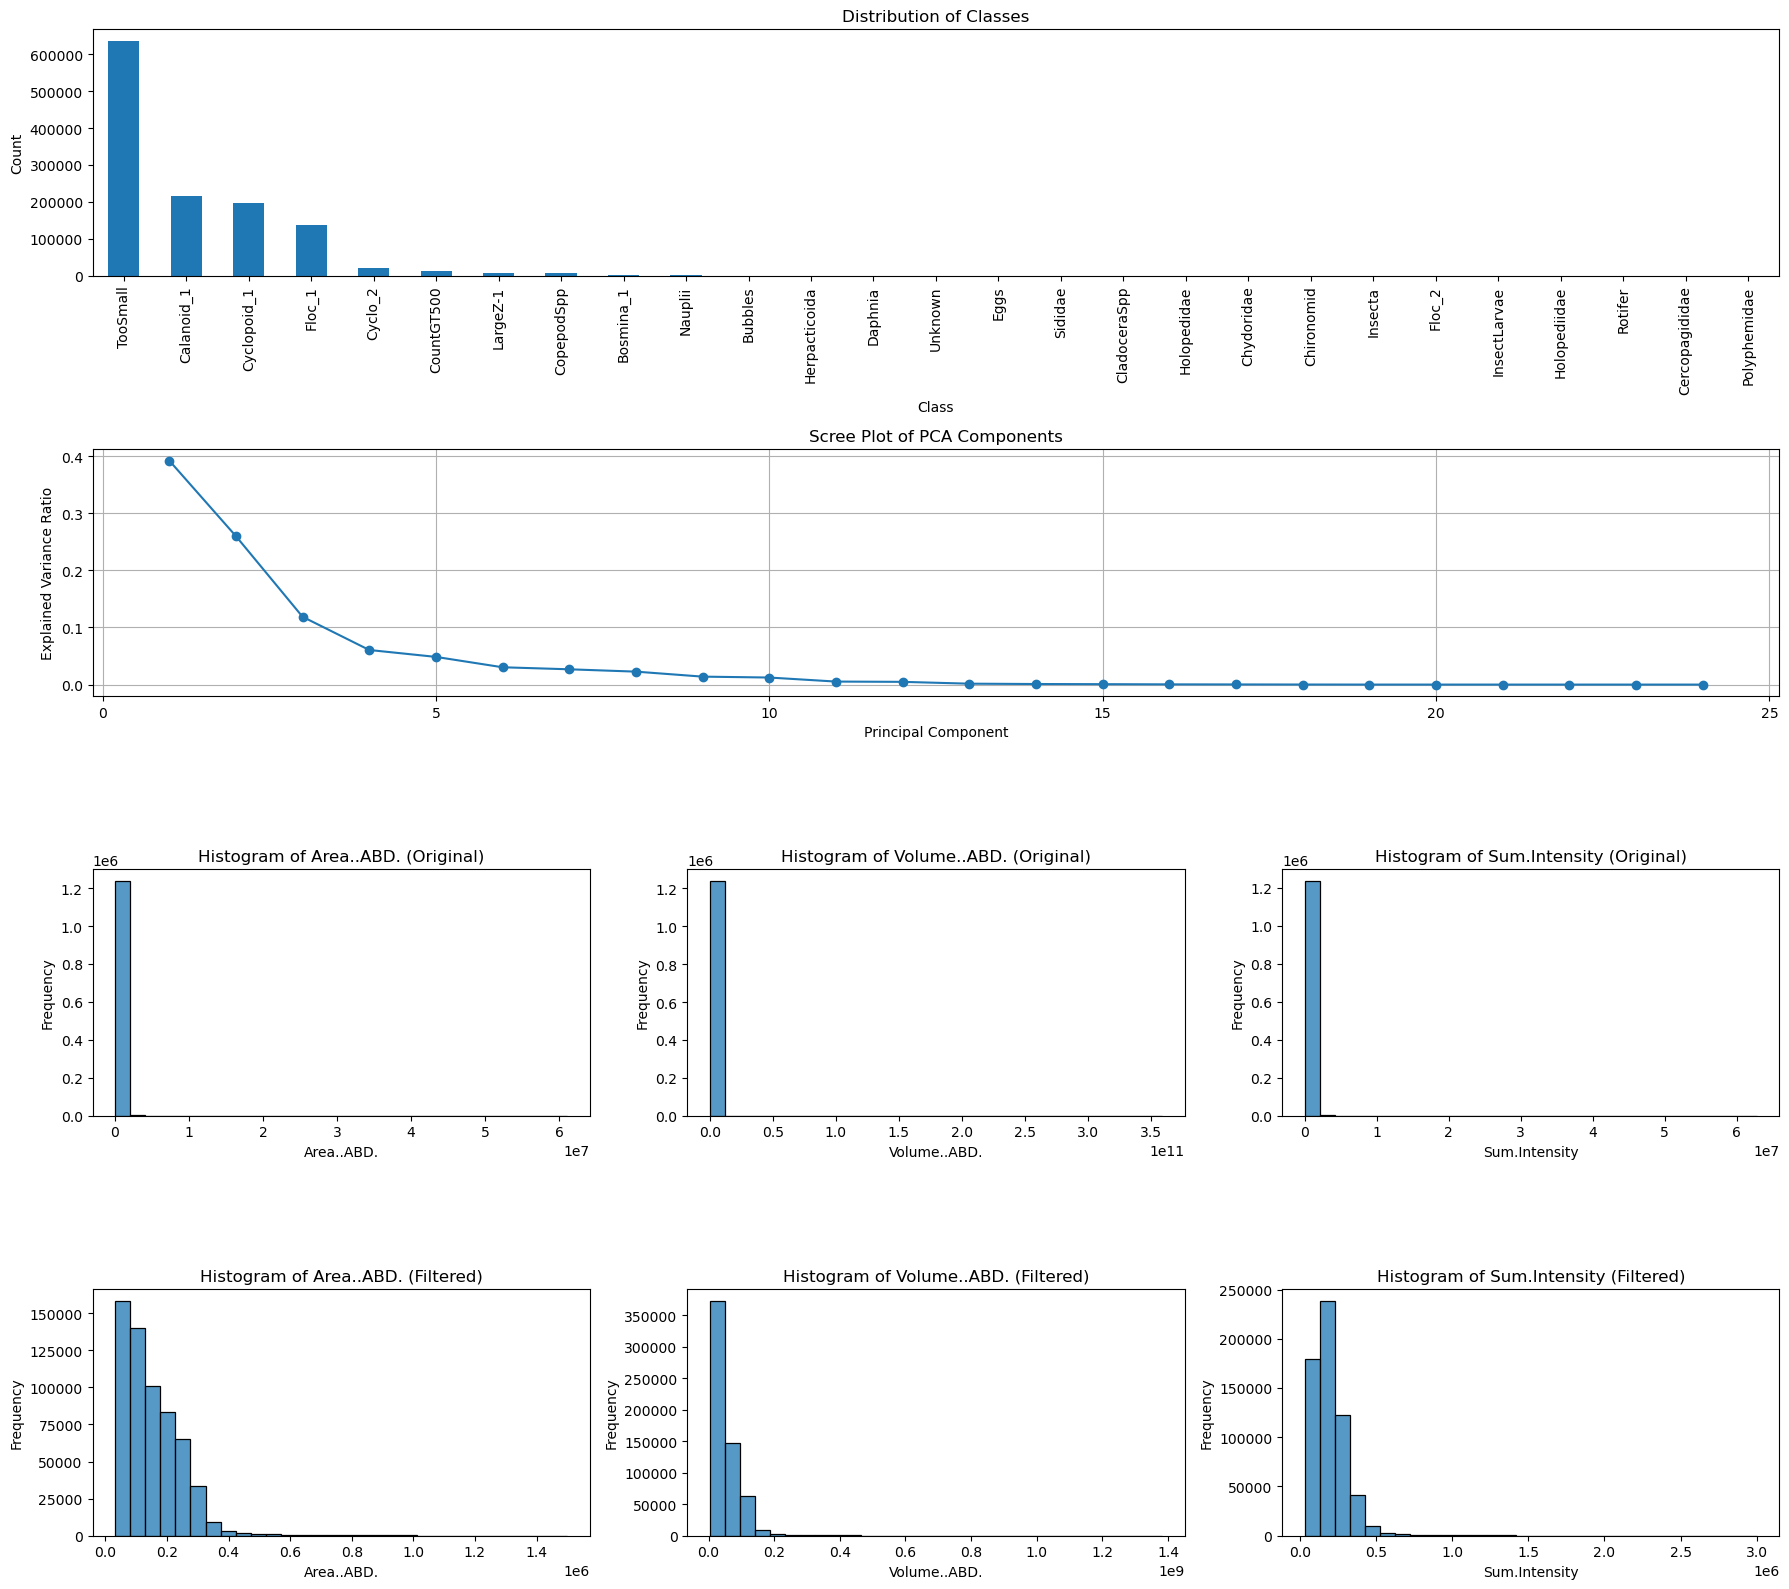

In [ ]:
# Data processing plots
import seaborn as sns
import matplotlib.gridspec as gridspec

area_volume_cols = ['Area..ABD.', 'Volume..ABD.', 'Sum.Intensity']

fig = plt.figure(figsize=(18, 16))
gs = gridspec.GridSpec(4, 3, figure=fig)

# --- Class Distribution ---
ax0 = fig.add_subplot(gs[0, :])
class_counts.plot(kind='bar', ax=ax0)
ax0.set_title('Distribution of Classes')
ax0.set_xlabel('Class')
ax0.set_ylabel('Count')
ax0.tick_params(axis='x', rotation=90)

# --- Scree Plot ---
ax1 = fig.add_subplot(gs[1, :])
ax1.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-')
ax1.set_title('Scree Plot of PCA Components')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.grid(True)

# --- Histograms (Original) ---
for i, col in enumerate(area_volume_cols):
    ax = fig.add_subplot(gs[2, i])
    sns.histplot(original_df[col], bins=30, ax=ax)
    ax.set_title(f'Histogram of {col} (Original)')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

# --- Histograms (Filtered) ---
for i, col in enumerate(area_volume_cols):
    ax = fig.add_subplot(gs[3, i])
    sns.histplot(df[col], bins=30, ax=ax)
    ax.set_title(f'Histogram of {col} (Filtered)')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [133]:
# # Adjust the layout to a 2x3 grid
# fig = plt.figure(figsize=(18, 12))
# gs = gridspec.GridSpec(2, 3, figure=fig)

# # --- Histograms (Original) ---
# for i, col in enumerate(area_volume_cols):
#     if i >= 3:  # Limit to 3 columns for the first row
#         break
#     ax = fig.add_subplot(gs[0, i])
#     sns.histplot(data=original_df, x=col, bins=30, ax=ax)
#     ax.set_title(f'Histogram of {col} (Original)')
#     ax.set_xlabel(col)
#     ax.set_ylabel('Frequency')

# # --- Histograms (Filtered) ---
# for i, col in enumerate(area_volume_cols):
#     if i >= 3:  # Limit to 3 columns for the second row
#         break
#     ax = fig.add_subplot(gs[1, i])
#     sns.histplot(data=df, x=col, bins=30, ax=ax)
#     ax.set_title(f'Histogram of {col} (Filtered)')
#     ax.set_xlabel(col)
#     ax.set_ylabel('Frequency')

# plt.tight_layout()
# plt.show()

## Models
I will test various statistical and machine learning models, including logistic regression and XGBoost.

The goal is to classify the seven plankton classes of interest while also identifying "Others" for plankton outside this list. One approach to achieving this is hierarchical classification. This involves training a binary classifier to differentiate Known vs. Others, and if a sample is classified as Known, a second classifier predicts the specific plankton type. Therefore there will be three steps for models, which are train model for binary classification, train model for multiclass classification, and combine them. 

Eventually we split dataset into two. First we need to split the dataset into two, one will be used to train binary and multiclass model and the other will be used to test with combined model of binary and multiclass. To do this, we can avoid data double dipping. However, I decided to use same data for binary and multiclass training since we have fully independent test set for combined model testing. 

Given the class imbalance in the data, especially among the seven focal plankton classes, I applied SMOTE (Synthetic Minority Oversampling Technique) to augment underrepresented classes including `'Bosmina_1'`, `'Herpacticoida'`, `'Chironomid'`, `'Chydoridae'`, `'Daphnia'`. I manually adjusted the target sizes for oversampling to avoid introducing too much duplication and noise, which would degrade performance.

In [72]:
# Data processing
from sklearn.model_selection import train_test_split

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

known_classes = ["Calanoid_1", "Cyclopoid_1", "Bosmina_1", "Herpacticoida", "Chironomid", "Chydoridae", "Daphnia"]

# Known=1, Others=0
df.loc[:, "Known_vs_Others"] = df[target_col].apply(lambda x: 1 if x in known_classes else 0)

# Split dataset for testing hierarchically
X_train_hierarchical, X_test_hierarchical, y_train_hierarchical, y_test_hierarchical = train_test_split(
    X_pca, df["Known_vs_Others"], test_size=0.2, stratify=df["Known_vs_Others"], random_state=2453
)

# Split dataset for binary and multiclass classifier training and testing
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(
    X_train_hierarchical, y_train_hierarchical, test_size=0.2, stratify=y_train_hierarchical, random_state=2453)

# Subset only the known classes from the existing binary train/test sets
train_mask_known = (y_train_binary == 1)
test_mask_known = (y_test_binary == 1)

X_train_multiclass = X_train_binary[train_mask_known]
y_train_multiclass = df.loc[y_train_binary.index[train_mask_known], target_col]

X_test_multiclass = X_test_binary[test_mask_known]
y_test_multiclass = df.loc[y_test_binary.index[test_mask_known], target_col]

from imblearn.over_sampling import SMOTE

# Print original class distribution (before SMOTE)
before_smote = y_train_multiclass.value_counts()

# Apply SMOTE to balance the known classes
sampling_strategy = {
    "Bosmina_1": 18000,
    "Herpacticoida": 3700,
    "Daphnia": 3680,
    "Chydoridae": 330,
    "Chironomid": 230
}
smote = SMOTE(random_state=2453, sampling_strategy=sampling_strategy)
X_train_multiclass_res, y_train_multiclass_res = smote.fit_resample(X_train_multiclass, y_train_multiclass)

# Print new class distribution (after SMOTE)
after_smote = pd.Series(y_train_multiclass_res).value_counts()

# Create a table for before and after SMOTE results
smote_table = pd.DataFrame({
    "Class": before_smote.index,
    "Before SMOTE": before_smote.values,
    "After SMOTE": after_smote.reindex(before_smote.index, fill_value=0).values
})

print("\nSMOTE Results Table:")
print(smote_table)



SMOTE Results Table:
           Class  Before SMOTE  After SMOTE
0     Calanoid_1        137869       137869
1    Cyclopoid_1        126557       126557
2      Bosmina_1          1859        18000
3  Herpacticoida           371         3700
4        Daphnia           368         3680
5     Chydoridae            33          330
6     Chironomid            23          230


Now I will train logistic regression and XGBoost for binary classification and multiclass classification. After we finish training, we will try some combinations of the models in hierarchical classification.

### Logistic Regression 

Logistic regression requires several assumptions:

1. Linearly Separable Features: Zooplankton features are not linearly separable, but I will use logistic regression as a baseline due to its simplicity, interpretability, and ability to handle imbalanced classes.

2. No Multicollinearity: Since some features are highly correlated, I applied PCA as part of exploratory data analysis (EDA). The scree plot analysis suggested using seven principal components.

3. Standardized Features: Since feature ranges vary significantly, I standardized all features.

### XGBoost 

As you can see in Result section, since logistic regression shows bad performance in multiclass classification and has potential risk in binary classification, I moved on tree based model, specifically XGBoost. 

There are some reasons I choose XGBoost.
1. XGBoost does not require strict distributional assumptions. 
2. XGBoost handles nonlinear data well and interact between features automatically. 
3. XGBoost handles imbalanced calsses better than other tree based models.
4. XGBoost is also efficient and scales well with large datasets. 
Since our data has wide range of features as well as highly imbalanced classes, XGBoost can help increase model performance. 

# Results
## Logistic Regression
### Binary Classification
Logistic regression performed reasonably well in distinguishing between Known and Other plankton classes, achieving an accuracy of 88%. It had a high recall (0.99) for the `'Known'` class but much lower recall (0.64) for the `'Other'` class. This means many samples from outside the target classes were incorrectly classified as `'Known'`. While the model is interpretable and fast, its linear decision boundary likely limited its ability to handle complex feature relationships.

### Multicalss Classification
When applied to the seven `'Known'` plankton classes, logistic regression performed poorly. It achieved an overall accuracy of 55%, with especially low F1-scores for rare classes such as Chironomid, Chydoridae, Daphnia, and Herpacticoida. These results indicate that logistic regression is not suitable for heavily imbalanced or nonlinearly separable data in multiclass settings.

In [111]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Binary Classifier
clf_binary = LogisticRegression()
clf_binary.fit(X_train_binary, y_train_binary)

y_pred = clf_binary.predict(X_test_binary)
print("Logistic Regression Binary Classification Report:")
print(pd.DataFrame(classification_report(y_test_binary, y_pred, output_dict=True)).transpose())

# Multiclass Classifier
clf_multiclass = LogisticRegression(class_weight="balanced", max_iter=1000)
clf_multiclass.fit(X_train_multiclass_res, y_train_multiclass_res)

y_known_pred = clf_multiclass.predict(X_test_multiclass)
print("\nLogistic Regression Multiclass Classification Report:")
print(pd.DataFrame(classification_report(y_test_multiclass, y_known_pred, output_dict=True)).transpose())

Logistic Regression Binary Classification Report:
              precision    recall  f1-score       support
0              0.957513  0.641950  0.768602  29454.000000
1              0.862104  0.987435  0.920523  66771.000000
accuracy       0.881684  0.881684  0.881684      0.881684
macro avg      0.909808  0.814692  0.844563  96225.000000
weighted avg   0.891308  0.881684  0.874021  96225.000000

Logistic Regression Multiclass Classification Report:
               precision    recall  f1-score       support
Bosmina_1       0.406402  0.899142  0.559786    466.000000
Calanoid_1      0.876004  0.543240  0.670611  34320.000000
Chironomid      0.000957  0.571429  0.001912      7.000000
Chydoridae      0.000194  0.200000  0.000389      5.000000
Cyclopoid_1     0.776055  0.562221  0.652054  31774.000000
Daphnia         0.011489  0.606742  0.022552     89.000000
Herpacticoida   0.009033  0.609091  0.017803    110.000000
accuracy        0.554927  0.554927  0.554927      0.554927
macro avg       

## XGBoost
### Binary Classification
XGBoost substantially outperformed logistic regression in binary classification, reaching an accuracy of 91%. It maintained high precision and recall across both `'Known'` and `'Other'` classes. The model was better able to identify and separate `'Known'` samples, reducing false positives and minimizing downstream misclassification in the hierarchical pipeline.

### Multiclass Classification
XGBoost achieved excellent performance when classifying the seven `'Known'` plankton classes directly. The overall accuracy was 91%, and class-level precision and recall were high even for minor classes such as Bosmina_1, Daphnia, and Herpacticoida. These results highlight XGBoost’s capacity to model nonlinear relationships and effectively handle class imbalance.

In [ ]:
# Import necessary modules
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

# Encode target labels
label_encoder = LabelEncoder()
y_train_multiclass_encoded = label_encoder.fit_transform(y_train_multiclass_res)
y_test_multiclass_encoded = label_encoder.transform(y_test_multiclass)

# XGBoost Model with Hyperparameter Tuning
param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}

xgb_clf = XGBClassifier(eval_metric="mlogloss", random_state=2453)

# Create the base classifier
xgb_binary = XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=2453)

# Hyperparameter search
random_search_binary = RandomizedSearchCV(
    xgb_clf, param_distributions=param_dist, 
    n_iter=20, scoring="f1", cv=5, verbose=1, n_jobs=-1
)

# Fit on binary classification task
random_search_binary.fit(X_train_binary, y_train_binary)

# Best model
best_xgb_binary = random_search_binary.best_estimator_

# Cross-validation performance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2453)
scores = cross_val_score(best_xgb_binary, X_train_binary, y_train_binary, cv=cv, scoring="f1")

# Final test evaluation
y_pred_binary = best_xgb_binary.predict(X_test_binary)
print("\nXGBoost Binary Classification Report")
print(pd.DataFrame(classification_report(y_test_binary, y_pred_binary, output_dict=True)).transpose())

Fitting 5 folds for each of 20 candidates, totalling 100 fits

XGBoost Ninary Classification Report
              precision    recall  f1-score       support
0              0.940938  0.764820  0.843787  29454.000000
1              0.904170  0.978823  0.940017  66771.000000
accuracy       0.913318  0.913318  0.913318      0.913318
macro avg      0.922554  0.871821  0.891902  96225.000000
weighted avg   0.915424  0.913318  0.910561  96225.000000


In [ ]:
# Randomized Search for Hyperparameter Optimization
random_search = RandomizedSearchCV(
    xgb_clf, param_distributions=param_dist, 
    n_iter=20, scoring="f1_weighted", cv=5, verbose=1, n_jobs=-1
)

random_search.fit(X_train_multiclass_res, y_train_multiclass_encoded)

# Best model
best_xgb = random_search.best_estimator_

# Cross-validation to evaluate model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2453)
scores = cross_val_score(best_xgb, X_train_multiclass_res, y_train_multiclass_encoded, cv=cv, scoring="f1_weighted")

# Class prediction
y_pred = best_xgb.predict(X_test_multiclass)
y_pred = label_encoder.inverse_transform(y_pred)

print("XGBoost Multiclass Classification Report:")
print(pd.DataFrame(classification_report(y_test_multiclass, y_pred, output_dict=True)).transpose())

Fitting 5 folds for each of 20 candidates, totalling 100 fits
XGBoost Multiclass Classification Report:
               precision    recall  f1-score       support
Bosmina_1       0.818363  0.879828  0.847983    466.000000
Calanoid_1      0.918771  0.921474  0.920120  34320.000000
Chironomid      0.250000  0.142857  0.181818      7.000000
Chydoridae      0.000000  0.000000  0.000000      5.000000
Cyclopoid_1     0.914815  0.912224  0.913518  31774.000000
Daphnia         0.473684  0.404494  0.436364     89.000000
Herpacticoida   0.380952  0.290909  0.329897    110.000000
accuracy        0.914903  0.914903  0.914903      0.914903
macro avg       0.536655  0.507398  0.518529  66771.000000
weighted avg    0.914569  0.914903  0.914711  66771.000000


## Hierarchical Classification

To combine the benefits of the binary/multiclass separation, I implemented a hierarchical classification structure. This reduced the confusion between target and non-target classes by filtering out irrelevant samples early.

Three combinations were tested:

* Logistic → Logistic: Accuracy = 58%
Moderate improvement over flat logistic regression, but still limited by both models’ weaknesses.

* Logistic → XGBoost: Accuracy = 82%
Significant improvement, as the more capable XGBoost model handled multiclass classification after a basic filtering step by logistic regression.

* XGBoost → XGBoost: Accuracy = 85%
This was the best-performing configuration. With accurate filtering and robust multiclass prediction, this model achieved the highest precision and recall across the board.


In [128]:
class HierarchicalClassifier:
    def __init__(self, binary_model=None, multiclass_model=None, assume_fitted=False):
        """
        Initializes the Hierarchical Classifier.
        - binary_model: Model to classify Known vs. Others (default: Logistic Regression)
        - multiclass_model: Model to classify Known classes (default: Logistic Regression)
        """
        self.binary_model = binary_model or LogisticRegression(max_iter=1000)
        self.multiclass_model = multiclass_model or LogisticRegression(class_weight="balanced", max_iter=1000)
        self.is_fitted = assume_fitted  # Track if the model has been trained
    
    def fit(self, X_train, y_train, X_train_multiclass, y_train_multiclass):
        """
        Trains both binary and multiclass classifiers.
        """
        # print("Training Binary Classifier...")
        self.binary_model.fit(X_train, y_train)
        
        # print("Training Multiclass Classifier...")
        self.multiclass_model.fit(X_train_multiclass, y_train_multiclass)
        
        self.is_fitted = True  # Model is now trained
        # print("Training Complete.")

    def predict(self, X_test):
        """
        Predicts labels using the hierarchical pipeline.
        - First, applies the binary classifier.
        - If classified as "Known", applies the multiclass classifier.
        """
        if not self.is_fitted:
            raise ValueError("Model is not trained. Call `.fit()` first.")
        
        # print("Making Predictions...")
        binary_preds = self.binary_model.predict(X_test)
        # binary_probs = self.binary_model.predict_proba(X_test)[:, 1]  # probability of being "Known"
        # binary_preds = (binary_probs > 0.85).astype(int)  # only allow confident samples
        
        final_predictions = np.full_like(binary_preds, fill_value="Other", dtype=object)  # Default to "Other"
        known_mask = (binary_preds == 1)  # Identify Known samples
        
        if np.any(known_mask):  # Only predict multiclass if there are Known samples
            # final_predictions[known_mask] = self.multiclass_model.predict(X_test[known_mask])
            known_preds = self.multiclass_model.predict(X_test[known_mask])
            
            # Safe decoding: only inverse_transform if predictions are numeric
            if np.issubdtype(known_preds.dtype, np.integer):
                known_preds = label_encoder.inverse_transform(known_preds)

        final_predictions[known_mask] = known_preds
        
        return final_predictions
    
    def evaluate(self, X_test, y_test, y_test_multiclass, models):
        """
        Evaluates the model using classification reports.
        """
        y_pred = self.predict(X_test)

        # binary_preds = self.binary_model.predict(X_test)
        # print("\n[Binary Classifier: Known vs Other]")
        # print(classification_report(y_test, binary_preds))

        # Map ground truth correctly
        y_test_mapped = np.where(y_test == 1, y_test_multiclass, "Other")

        # print(pd.DataFrame(classification_report(y_test_mapped, y_pred, zero_division=0, output_dict=True)).transpose())
        # Generate classification report
        report_dict = classification_report(y_test_mapped, y_pred, output_dict=True, zero_division=0)
        df_report = pd.DataFrame(report_dict).transpose()

        # Convert support to integer, round other values
        df_report["support"] = df_report["support"].astype(int)
        df_report = df_report.round(4)
        
        for col in ["precision", "recall", "support"]:
            df_report[col] = df_report[col].astype("object")
        df_report.loc["accuracy", ["precision", "recall", "support"]] = [""] * 3

        # Insert blank row
        blank_row = pd.Series({col: "" for col in df_report.columns}, name="")
        insert_idx = df_report.index.tolist().index("accuracy")
        df_report = pd.concat([
            df_report.iloc[:insert_idx],
            pd.DataFrame([blank_row]),
            df_report.iloc[insert_idx:]
])

        # Insert blank row above "accuracy"
        blank_row = pd.Series({col: "" for col in df_report.columns}, name="")
        idx = df_report.index.tolist()
        insert_idx = idx.index("accuracy")
        df_report = pd.concat([
            df_report.iloc[:insert_idx],
            pd.DataFrame([blank_row]),
            df_report.iloc[insert_idx:]
        ])

        # Display
        print(f"Final Hierarchical Classification Performance for {models}:")
        print(df_report)

In [129]:
model_both_logistic_regression = HierarchicalClassifier(
    binary_model=clf_binary,
    multiclass_model=clf_multiclass,
    assume_fitted=True
)

y_pred = model_both_logistic_regression.predict(X_test_hierarchical)

model_both_logistic_regression.evaluate(X_test_hierarchical, y_test_hierarchical, df.loc[y_test_hierarchical.index, target_col], "Logistic Regression")

Final Hierarchical Classification Performance for Logistic Regression:
              precision  recall f1-score support
Bosmina_1         0.241  0.9055   0.3807     550
Calanoid_1       0.7863  0.5405   0.6406   43025
Chironomid       0.0008  0.7143   0.0016       7
Chydoridae          0.0     0.0      0.0       5
Cyclopoid_1      0.6792  0.5619    0.615   39651
Daphnia          0.0076  0.5051    0.015      99
Herpacticoida    0.0081  0.6825   0.0161     126
Other            0.9587  0.6419    0.769   36818
                                                
                                                
accuracy                          0.5803        
macro avg        0.3352  0.5689   0.3047  120281
weighted avg     0.7998  0.5803    0.669  120281


In [130]:
model_logistic_regression_xgboost = HierarchicalClassifier(
    binary_model=clf_binary,
    multiclass_model=best_xgb,
    assume_fitted=True
)

y_pred = model_logistic_regression_xgboost.predict(X_test_hierarchical)

model_logistic_regression_xgboost.evaluate(X_test_hierarchical, y_test_hierarchical, df.loc[y_test_hierarchical.index, target_col], "Logistic Regression + XGBoost")

Final Hierarchical Classification Performance for Logistic Regression + XGBoost:
              precision  recall f1-score support
Bosmina_1        0.4227  0.8855   0.5723     550
Calanoid_1       0.8195  0.9083   0.8616   43025
Chironomid        0.037  0.1429   0.0588       7
Chydoridae          0.0     0.0      0.0       5
Cyclopoid_1      0.7719  0.9025   0.8321   39651
Daphnia          0.1542  0.3131   0.2067      99
Herpacticoida    0.2245  0.3492   0.2733     126
Other            0.9587  0.6419    0.769   36818
                                                
                                                
accuracy                          0.8236        
macro avg        0.4236  0.5179   0.4467  120281
weighted avg     0.8434  0.8236    0.821  120281


In [131]:
model_both_xgboost = HierarchicalClassifier(
    binary_model=best_xgb_binary,
    multiclass_model=best_xgb,
    assume_fitted=True
)

y_pred = model_both_xgboost.predict(X_test_hierarchical)

model_both_xgboost.evaluate(X_test_hierarchical, y_test_hierarchical, df.loc[y_test_hierarchical.index, target_col], "XGBoost")

Final Hierarchical Classification Performance for XGBoost:
              precision  recall f1-score support
Bosmina_1        0.6088  0.7018    0.652     550
Calanoid_1       0.8514  0.9055   0.8776   43025
Chironomid          0.0     0.0      0.0       7
Chydoridae          0.0     0.0      0.0       5
Cyclopoid_1      0.8091  0.8953     0.85   39651
Daphnia          0.1869   0.202   0.1942      99
Herpacticoida    0.3462  0.2857    0.313     126
Other            0.9407  0.7615   0.8417   36818
                                                
                                                
accuracy                          0.8558        
macro avg        0.4679   0.469   0.4661  120281
weighted avg     0.8625  0.8558   0.8553  120281


# Conclusion
This project explored the use of machine learning to automate the classification of zooplankton based on geometric and environmental features. Careful data preprocessing was essential, including the removal of noisy classes, filtering out outliers, applying log transformation and standardization, and addressing class imbalance through targeted oversampling. These steps helped improve the reliability of the models.

Logistic regression served as a useful baseline model due to its simplicity and interpretability. However, it showed clear limitations when dealing with nonlinear feature relationships and severely imbalanced class distributions. In contrast, XGBoost performed significantly better in both binary and multiclass classification tasks. Its ability to model complex interactions and its robustness to data imbalance made it a strong candidate for this classification problem.

To improve classification performance further, a hierarchical classification framework was implemented. This structure first identified whether a sample belonged to one of the target plankton classes before applying a second model to predict the specific class. The hierarchical approach helped reduce confusion between relevant and irrelevant samples and led to notable performance improvements. The best results were achieved when XGBoost was used for both stages of the hierarchical pipeline, resulting in an overall accuracy of 85 percent.

In summary, the combination of structured preprocessing, hierarchical classification, and XGBoost produced the most effective model for zooplankton classification. Future extensions could explore the use of raw image data through deep learning, incorporate spatial and seasonal features, or apply cost-sensitive learning to further improve classification of rare plankton classes.